### **DeBiFomer : Transformer avec Attention Déformable et Routage Bi-niveau**


Le DeBiFormer (Deformable Bi-level Transformer) est une architecture avancée de Vision Transformer qui intègre l'Attention Déformable et le Routage Bi-niveau afin d'optimiser l'efficacité et les performances dans le traitement des images. Dans ce contexte, le DeBiFormer est utilisé pour la classification d'images, tirant parti de ces techniques pour améliorer la précision et la rapidité du processus.

La classe **GELU** implémente une fonction d'activation GELU (Gaussian Error Linear Unit) qui introduit de la non-linéarité dans le modèle. Elle offre deux variantes :

* Approche exacte : Elle utilise la fonction d'erreur (erf) pour calculer l'approximation exacte



* Approximation : Elle calcule l'activation en utilisant une approximation basée sur la fonction tanh, ce qui simplifie les calculs et peut être plus rapide en termes de performance tout en offrant une précision suffisante pour certaines applications.

In [57]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.layers import Layer
from tensorflow.keras import layers as nn
from einops.layers.tensorflow import Rearrange

class GELU(Layer):
    def __init__(self, approximate=False):
        super(GELU, self).__init__()
        self.approximate = approximate

    def call(self, x):
        if self.approximate:
            coeff = tf.cast(0.044715, x.dtype)
            return 0.5 * x * (1.0 + tf.tanh(0.7978845608028654 * (x + coeff * tf.pow(x, 3))))
        else:
            return 0.5 * x * (1.0 + tf.math.erf(x / tf.cast(1.4142135623730951, x.dtype)))


La classe ***PreNorm*** effectue une normalisation sur les données d'entrée avant de les passer à une couche  suivant afin de stabiliser l'entraînement et améliorer la performance en réduisant les effets des gradients instables.

In [58]:
class PreNorm(Layer):
    def __init__(self, fn):
        super(PreNorm, self).__init__()
        self.norm = nn.LayerNormalization()
        self.fn = fn

    def call(self, x, training=True):
        return self.fn(self.norm(x), training=training)

La classe **DeformableAttention** implémente un mécanisme d'attention déformable. Ce mécanisme permet de mieux gérer la flexibilité des positions spatiales dans l'image en appliquant des offsets pour déformer les points de référence  , ce qui améliore la capacité du modèle à s'adapter aux structures complexes dans les données visuelles.

In [59]:
class DeformableAttention(Layer):
    """
    dim : La dimension de sortie de l'attention.
    num_heads : Le nombre de têtes d'attention (multi-head attention).
    dim_head : La dimension de chaque tête d'attention.
    dropout : Le taux de dropout utilisé après la projection de sortie.
    self.to_qkv : Une couche dense qui projette l'entrée x dans l'espace de dimension inner_dim * 3 pour obtenir les vecteurs de requête (Q), clé (K) et valeur (V).
    self.to_offset : Une couche dense pour générer des offsets (décalages) pour les points de référence dans l'attention déformable.
    self.to_out : Une séquence de couches qui projette la sortie après l'attention en dimension dim et applique un dropout.
    """
    #initialisation du paramétre
    def __init__(self, dim, num_heads, dim_head, dropout=0.):
        super().__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.scale = dim_head ** -0.5
        self.inner_dim = num_heads * dim_head

        self.to_qkv = nn.Dense(self.inner_dim * 3, use_bias=False)
        self.to_offset = nn.Dense(2 * num_heads)  # 2 pour coordonnées x,y
        self.to_out = Sequential([
            nn.Dense(dim),
            nn.Dropout(dropout)
        ])

    def get_reference_points(self, B, N):
        """
           La méthode get_reference_points génère des points de référence pour la séquence d'entrée en utilisant la fonction linspace,
           ce qui permet de créer une grille de points espacés régulièrement entre 0 et 1.
           Ces points servent de repères avant l'application de l'attention déformable.
           B: Taille du batch
           N :Nombre d'éléments dans la séquence
           """

        refs = tf.linspace(0., 1., N)  # génère une séquence de N valeurs, espacées uniformément entre 0 et 1.
        refs = tf.expand_dims(refs, -1)  # transforme la forme de refs en une matrice de forme [N, 1]
        refs = tf.tile(refs, [1, 2])  # répèter chaque valeur de refs deux fois pour créer une matrice de forme [N, 2] pour représenter les coordonnées (x, y)
        refs = tf.expand_dims(refs, 0)  # ajoute une dimension pour le batch, produisant une matrice de forme [1, N, 2]
        refs = tf.expand_dims(refs, 1)  # Ajoute une autre dimension pour les têtes d'attention
        refs = tf.tile(refs, [B, self.num_heads, 1, 1])  # duplique les points de référence sur toutes les têtes d'attention
        return refs

    def call(self, x, training=True):
        B, N, C = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]


        qkv = self.to_qkv(x)  # Projecter les données d'entrées sous forme de requête ,clé et valeur
        q, k, v = tf.split(qkv, 3, axis=-1)

        # #ajuster la structure de tensor pur qu'on puisse effectuer les calcules matricielles
        q = tf.reshape(q, (B, N, self.num_heads, self.dim_head))
        k = tf.reshape(k, (B, N, self.num_heads, self.dim_head))
        v = tf.reshape(v, (B, N, self.num_heads, self.dim_head))

        # [B, num_heads, N, dim_head]
        q = tf.transpose(q, [0, 2, 1, 3])
        k = tf.transpose(k, [0, 2, 1, 3])
        v = tf.transpose(v, [0, 2, 1, 3])

        # Calculer les offsets
        offsets = self.to_offset(x)  # [B, N, num_heads * 2]
        offsets = tf.reshape(offsets, (B, N, self.num_heads, 2))
        offsets = tf.transpose(offsets, [0, 2, 1, 3])  # [B, num_heads, N, 2]

        # Obtenir et déformer les points de référence
        ref_points = self.get_reference_points(B, N)  # [B, num_heads, N, 2]
        deformed_points = ref_points + offsets

        # Normaliser les points déformés
        deformed_points = tf.clip_by_value(deformed_points, 0., 1.)

        # Calcul de l'attention
        attn = tf.matmul(q, k, transpose_b=True) * self.scale
        attn = tf.nn.softmax(attn, axis=-1)

        # Appliquer l'attention
        out = tf.matmul(attn, v)  # [B, num_heads, N, dim_head]

        # Reshape et projection finale
        out = tf.transpose(out, [0, 2, 1, 3])  # [B, N, num_heads, dim_head]
        out = tf.reshape(out, (B, N, self.inner_dim))

        return self.to_out(out, training=training)


La classe **DebilevelRouting** sert a determiner comment l'information doit être distrubué et transformé à laide du point de routage qui seront appris pendant l'entrainement.


In [60]:

class DebilevelRouting(Layer):
    def __init__(self, dim, num_heads, dim_head, dropout=0):
        super(DebilevelRouting, self).__init__()
        self.num_heads = num_heads
        self.dim_head = dim_head
        self.dropout = nn.Dropout(dropout)

        # les poids de routage sont initialisé par "glorot_uniform"
        self.routing_weights = self.add_weight(
            shape=(dim, dim),
            initializer="glorot_uniform",
            trainable=True,
            name="routing_weights"
        )

    def call(self, x, training=True):
        # transformation linéaire du matrice des poids
        out = tf.matmul(x, self.routing_weights)
        return self.dropout(out, training=training)


La classe **DeBiFormerBlock** combine DeformableAttention ainsi que DebiformerBlock afin de mieux analyser les relations complexe .

In [61]:

class DeBiFormerBlock(Layer):
    def __init__(self, dim, num_heads, dim_head, mlp_dim, dropout=0):
        super(DeBiFormerBlock, self).__init__()
        self.dim = dim
        self.attn = PreNorm(DeformableAttention(dim, num_heads, dim_head, dropout))
        self.routing = PreNorm(DebilevelRouting(dim, num_heads, dim_head, dropout))

        self.mlp = PreNorm(Sequential([
            nn.Dense(mlp_dim),
            GELU(),
            nn.Dropout(dropout),
            nn.Dense(dim),
            nn.Dropout(dropout)
        ]))

    def call(self, x, training=True):
        # Attention
        attn_out = self.attn(x, training=training)
        # Routing
        routed_out = self.routing(attn_out, training=training)
        # Residual connections
        x = x + routed_out
        x = x + self.mlp(x, training=training)
        return x

La classe **Debiformer** est une implémentation compléte de l'approche DBRA qui suit le processus VIT en appliquant l'attention deformable ainsi que le routage pour mieux améliorer la performance du modéle .

In [62]:
class DeBiFormer(Model):
    def __init__(self,image_size ,patch_size ,num_classes ,dim,depth ,heads ,mlp_dim ,dim_head=64 ,dropout=0 ,emb_dropout=0):
        super(DeBiFormer, self).__init__()

        image_height, image_width = (image_size, image_size) if isinstance(image_size, int) else image_size
        patch_height, patch_width = (patch_size, patch_size) if isinstance(patch_size, int) else patch_size

        num_patches = (image_height // patch_height) * (image_width // patch_width)
        patch_dim = 3 * patch_height * patch_width

        self.patch_embed = Sequential([
            Rearrange('b (h p1) (w p2) c -> b (h w) (p1 p2 c)',
                     p1=patch_height, p2=patch_width),
            nn.Dense(dim)
        ])

        self.cls_token = self.add_weight(
            shape=(1, 1, dim),
            initializer="zeros",
            trainable=True,
            name="cls_token"
        )
        self.pos_embed = self.add_weight(
            shape=(1, num_patches + 1, dim),
            initializer="zeros",
            trainable=True,
            name="pos_embed"
        )
        self.dropout = nn.Dropout(emb_dropout)

        self.transformer = [
            DeBiFormerBlock(dim, heads, dim_head, mlp_dim, dropout)
            for _ in range(depth)
        ]

        self.mlp_head = Sequential([
            nn.LayerNormalization(),
            nn.Dense(num_classes)
        ])

    def call(self, img, training=True):
      #projecter les données dans un espace vectorielle
        x = self.patch_embed(img)
        b, n = tf.shape(x)[0], tf.shape(x)[1]
        #ajouter le token de classification
        cls_tokens = tf.tile(self.cls_token, [b, 1, 1])
        x = tf.concat([cls_tokens, x], axis=1)
        #ajouter le positionnement
        x = x + self.pos_embed
        x = self.dropout(x, training=training)
        #Attention Debiformer
        for block in self.transformer:
            x = block(x, training=training)

        return self.mlp_head(x[:, 0])

In [63]:
# Create a DeBiFormer instance
v = DeBiFormer(
    image_size=(32, 32),
    patch_size=(8, 8),
    num_classes=10,
    dim=64,
    depth=6,
    heads=8,
    mlp_dim=128,
    dropout=0.3,
    emb_dropout=0.3
)




Le modèle est entraîné sur le dataset CIFAR-10, qui contient un total de 60 000 images réparties en 10 classes. Parmi ces images, 50 000 sont utilisées pour l'entraînement et 10 000 pour les tests. Dans notre cas, nous avons divisé les données d'entraînement en deux parties : 80% pour l'entraînement du modèle et 20% pour la validation.

In [64]:
import keras
num_classes = 10
input_shape = (32, 32, 3)
batch_size = 16

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
# Split training data into train and validation
validation_split = 0.3  # 30% pour validation
n_val = int(len(x_train) * validation_split)

# Données validation
x_val = x_train[:n_val]
y_val = y_train[:n_val]

# Données train restantes
x_train = x_train[n_val:]
y_train = y_train[n_val:]

# Création des datasets
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = test_dataset.batch(batch_size)
optimizer = tf.keras.optimizers.Adam()
# Instantiate a loss function.
loss_fn = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
val_acc_metric = tf.keras.metrics.CategoricalAccuracy()
test_acc_metric = tf.keras.metrics.CategoricalAccuracy()


x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 10)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 10)


Le modèle est entraîné pendant 15 époques, au cours desquelles nous calculons les performances sur les jeux de données d'entraînement, de validation et de test à chaque époque

In [65]:
import time
@tf.function
def train_step(x, y):
    with tf.GradientTape() as tape:
        logits = v(x, training=True)
        loss_value = loss_fn(y, logits)
        # print(loss_value)
    grads = tape.gradient(loss_value, v.trainable_weights)
    # print(2)
    optimizer.apply_gradients(zip(grads, v.trainable_weights))
    # print(3)
    logits = v(x,training=False)
    train_acc_metric.update_state(y, logits)
    return loss_value
@tf.function
def test_step(x_batch, y_batch):
    logits = v(x_batch, training=False)
    loss = loss_fn(y_batch, logits)
    print(f"Test Step - Loss: {loss}, Logits: {logits}")
    return loss, logits
train_acc_list=[]
train_loss_list=[]
val_acc_list = []
val_loss_list = []
test_acc_list = []
test_loss_list = []

epochs = 50
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    start_time = time.time()
    train_loss = []
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        loss_value = train_step(x_batch_train, y_batch_train)
        train_loss.append(float(loss_value))
        if step % 200 == 0:
            print(
                "Training loss (for one batch) at step %d: %.4f"
                % (step, float(loss_value))
            )
            print("Seen so far: %d samples" % ((step + 1) * batch_size))
    train_loss_list.append(np.mean(train_loss))
    train_acc = train_acc_metric.result()
    print("Training acc over epoch: %.4f" % (float(train_acc),))
    train_acc_list.append(float(train_acc))
    train_acc_metric.reset_state()
# Validation
    val_loss = []
    for x_batch_val, y_batch_val in val_dataset:
        v_loss, v_logits = test_step(x_batch_val, y_batch_val)
        val_loss.append(float(v_loss))
        val_acc_metric.update_state(y_batch_val, v_logits)

    val_loss_list.append(np.mean(val_loss))
    val_acc = float(val_acc_metric.result())
    print("Validation acc: %.4f" % (float(val_acc),))
    val_acc_list.append(val_acc)
    val_acc_metric.reset_state()

    # Test
    test_loss = []
    for x_batch_test, y_batch_test in test_dataset:
        t_loss, t_logits = test_step(x_batch_test, y_batch_test)
        test_loss.append(float(t_loss))
        test_acc_metric.update_state(y_batch_test, t_logits)

    test_loss_list.append(np.mean(test_loss))
    test_acc = float(test_acc_metric.result())
    print("test acc: %.4f" % (float(test_acc),))
    test_acc_list.append(test_acc)
    test_acc_metric.reset_state()

    print("Time taken: %.2fs" % (time.time() - start_time))


Start of epoch 0
Training loss (for one batch) at step 0: 2.3164
Seen so far: 16 samples
Training loss (for one batch) at step 200: 2.3222
Seen so far: 3216 samples
Training loss (for one batch) at step 400: 1.9178
Seen so far: 6416 samples
Training loss (for one batch) at step 600: 1.8056
Seen so far: 9616 samples
Training loss (for one batch) at step 800: 1.9524
Seen so far: 12816 samples
Training loss (for one batch) at step 1000: 1.9474
Seen so far: 16016 samples
Training loss (for one batch) at step 1200: 1.8710
Seen so far: 19216 samples
Training loss (for one batch) at step 1400: 1.8429
Seen so far: 22416 samples
Training loss (for one batch) at step 1600: 1.8784
Seen so far: 25616 samples
Training loss (for one batch) at step 1800: 1.9176
Seen so far: 28816 samples
Training loss (for one batch) at step 2000: 2.0440
Seen so far: 32016 samples
Training acc over epoch: 0.2742
Test Step - Loss: Tensor("categorical_crossentropy/truediv:0", shape=(), dtype=float32), Logits: Tensor("

Les graphiques montrent l'evolution d'accuracy ainsi du perte .

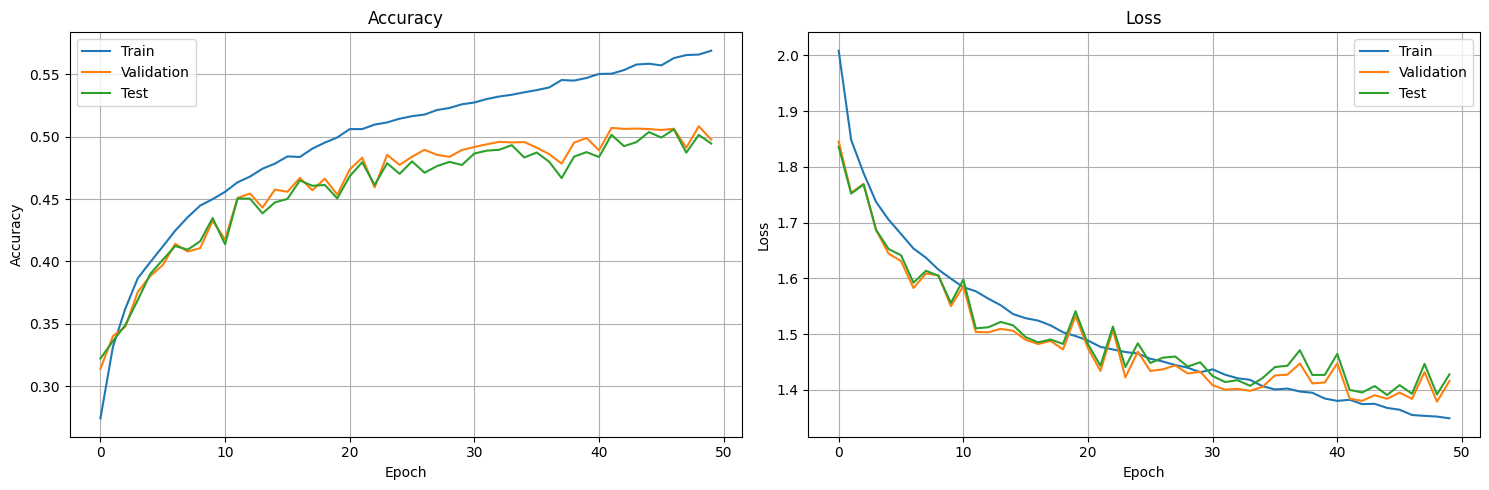

In [68]:
import matplotlib.pyplot as plt

# Plot metrics
plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.plot(train_acc_list, label='Train')
plt.plot(val_acc_list, label='Validation')
plt.plot(test_acc_list, label='Test')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(train_loss_list, label='Train')
plt.plot(val_loss_list, label='Validation')
plt.plot(test_loss_list, label='Test')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Matrice de confusion

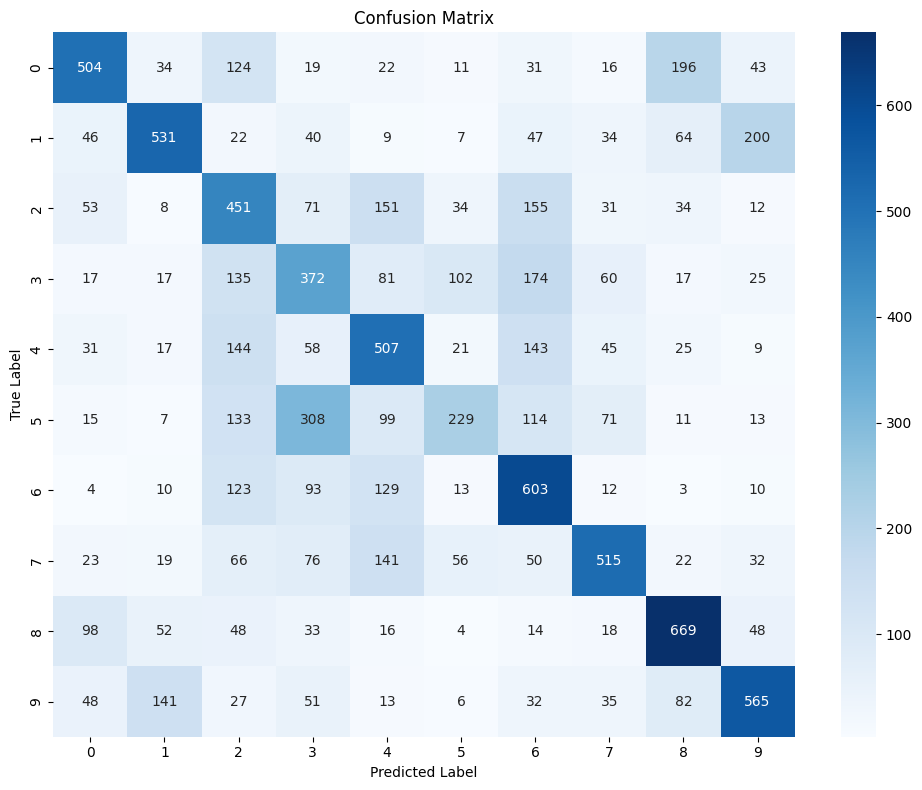

In [69]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def generate_confusion_matrix(model, x_test, y_test, num_classes=10):
    # Predict classes
    y_pred = model(x_test, training=False)
    y_pred_classes = tf.argmax(y_pred, axis=1)
    y_true_classes = tf.argmax(y_test, axis=1)

    # Generate confusion matrix
    confusion_matrix = tf.math.confusion_matrix(
        y_true_classes,
        y_pred_classes,
        num_classes=num_classes
    )

    # Visualization
    plt.figure(figsize=(10, 8))
    sns.heatmap(confusion_matrix,
                annot=True,
                fmt='d',
                cmap='Blues',
                xticklabels=range(num_classes),
                yticklabels=range(num_classes))
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.tight_layout()
    plt.show()

    return confusion_matrix

# Add this after your training loop
confusion_matrix = generate_confusion_matrix(v, x_test, y_test)